In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from global_config import *

In [5]:
labels_train = pd.read_csv(TRAIN_LABEL_PATH)
labels_test = pd.read_csv(TEST_LABEL_PATH)

count_nan_train = labels_train.isna().sum().sum()
count_nan_test = labels_test.isna().sum().sum()

length_train = len(labels_train)
length_test = len(labels_test)

if count_nan_test > 0: print(f"NaN in test:{count_nan_test}/{length_test} "
                             f"->{(100 * count_nan_test / length_test):.2f}%")

if count_nan_train > 0: print(f"NaN in train: {count_nan_train}/{length_train} "
                              f"-> {(100 * count_nan_train / length_train):.2f}%")

NaN in train: 150000/231723 -> 64.73%


In [8]:
n_sample_remove = int(14.73 / 100.0 * length_train)
negatives = labels_train[labels_train['EncodedPixels'].isna()]
drop_subset = negatives.sample(n=n_sample_remove, random_state=42)
labels_train = labels_train.drop(drop_subset.index)
count_nan_train = labels_train['EncodedPixels'].isna().sum()
print(f"NaN in train: {count_nan_train}/{length_train} -> {(100 * count_nan_train / length_train):.2f}%")

NaN in train: 115868/231723 -> 50.00%


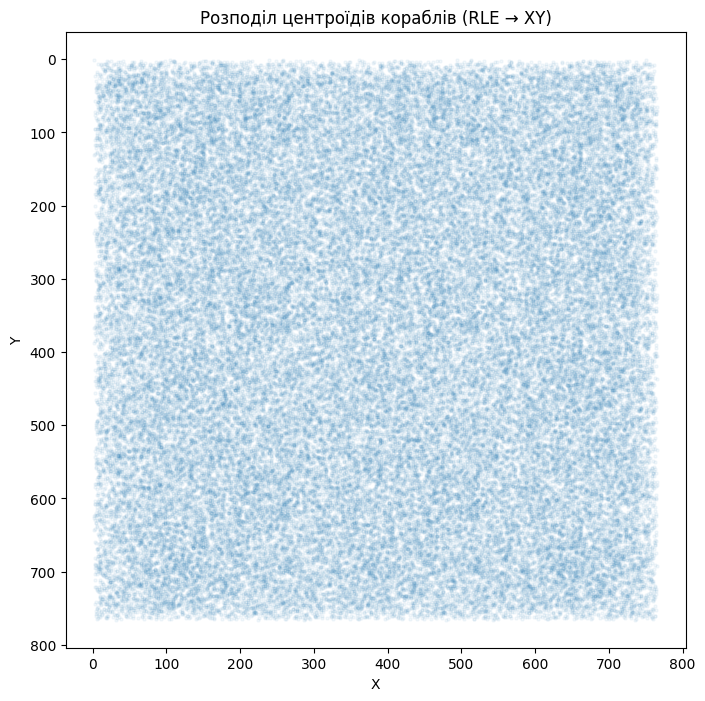

In [18]:
def rle_decode(
        rle_str: str,
        shape: tuple[int, int]
) -> np.ndarray:
    s = np.fromstring(rle_str, sep=' ', dtype=int)
    starts = s[0::2] - 1
    lengths = s[1::2]
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for start, length in zip(starts, lengths):
        mask[start:start + length] = 1
    return mask.reshape(shape, order='F')


centers_x, centers_y = [], []

for rle in labels_train['EncodedPixels'].dropna().values:
    mask = rle_decode(rle, shape=(768,768))
    ys, xs = np.where(mask == 1)
    centers_x.append(xs.mean())
    centers_y.append(ys.mean())

plt.figure(figsize=(8,8))
plt.scatter(centers_x, centers_y, s=5, alpha=0.05)
plt.gca().invert_yaxis()
plt.title("Розподіл центроїдів кораблів (RLE → XY)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

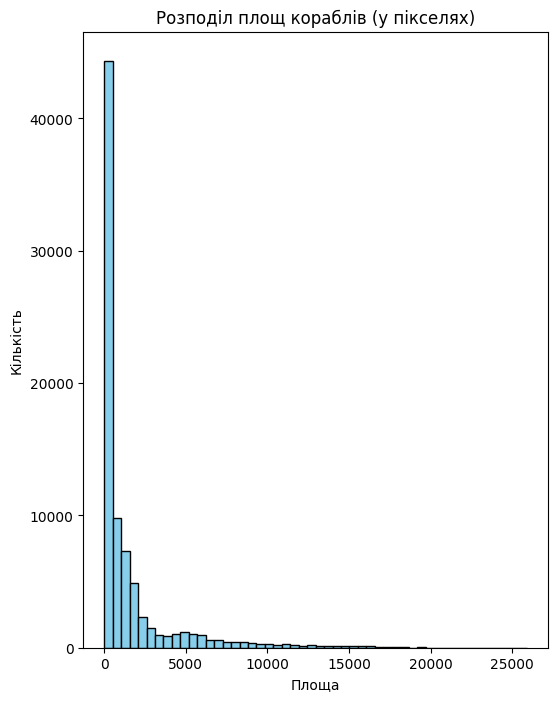

In [19]:
areas = []

for rle in labels_train['EncodedPixels'].dropna().values:
    mask = rle_decode(rle, shape=(768,768))
    ys, xs = np.where(mask == 1)
    areas.append(len(xs))

plt.figure(figsize=(6,8))
plt.hist(areas, bins=50, color="skyblue", edgecolor="black")
plt.title("Розподіл площ кораблів (у пікселях)")
plt.xlabel("Площа")
plt.ylabel("Кількість")
plt.show()


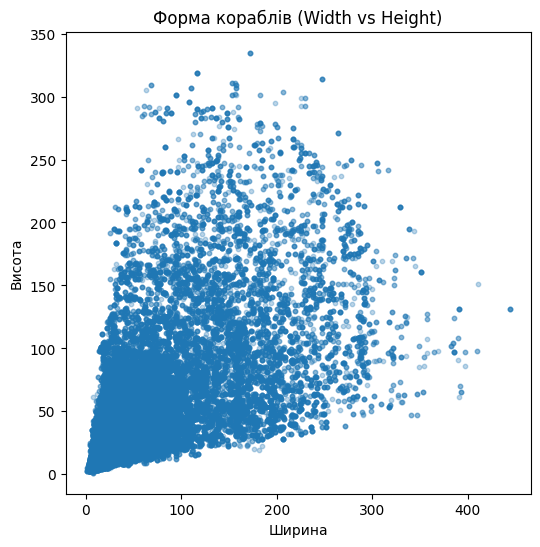

In [12]:
widths, heights = [], []

for rle in labels_train['EncodedPixels'].dropna().values:
    mask = rle_decode(rle, shape=(768,768))
    ys, xs = np.where(mask == 1)
    if len(xs) == 0:
        continue
    w, h = xs.max() - xs.min() + 1, ys.max() - ys.min() + 1
    widths.append(w)
    heights.append(h)

plt.figure(figsize=(6,6))
plt.scatter(widths, heights, s=10, alpha=0.3)
plt.xlabel("Ширина")
plt.ylabel("Висота")
plt.title("Форма кораблів (Width vs Height)")
plt.show()


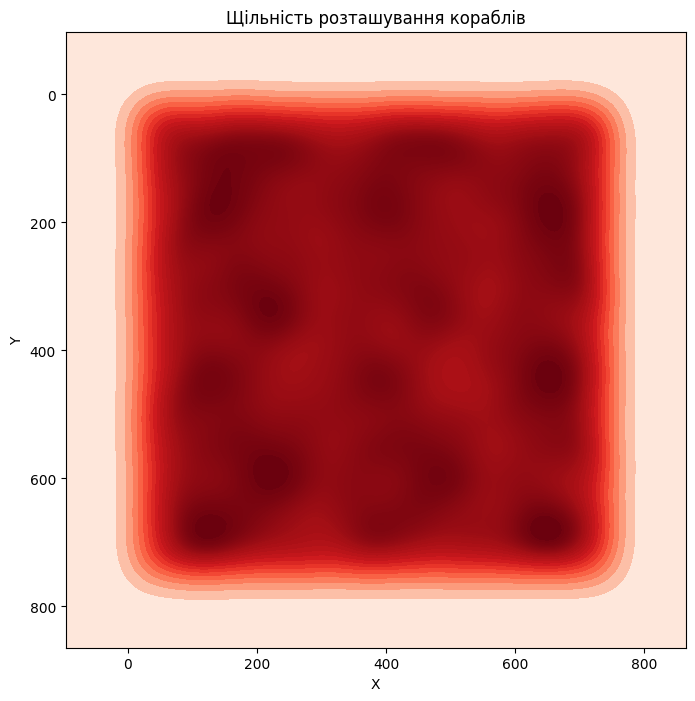

In [13]:
plt.figure(figsize=(8,8))
sns.kdeplot(x=centers_x, y=centers_y, fill=True, cmap="Reds", levels=50, thresh=0)
plt.gca().invert_yaxis()
plt.title("Щільність розташування кораблів")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


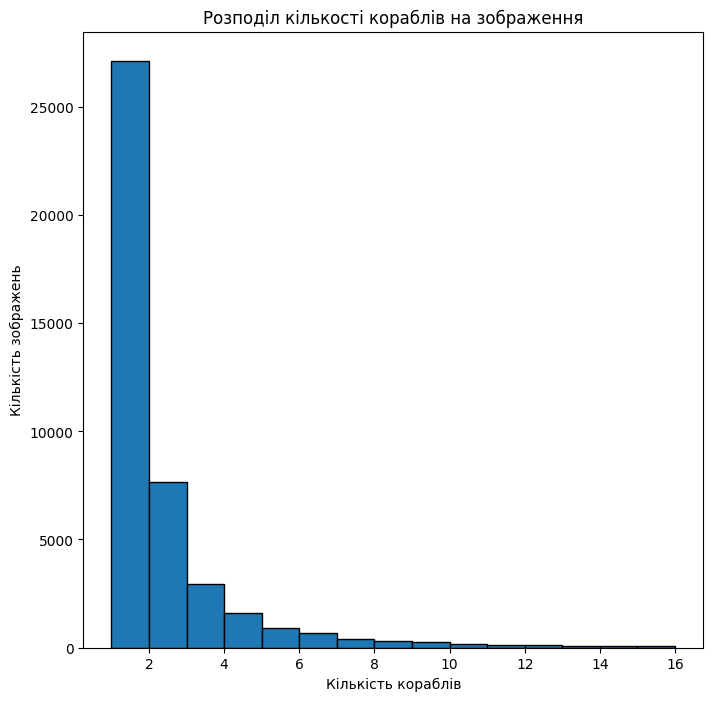

Середня кількість кораблів на зображення: 0.5158498712316316
Максимальна кількість кораблів на одному зображенні: 15


In [20]:

ships_per_image = labels_train.groupby("ImageId")["EncodedPixels"].count()

plt.figure(figsize=(8,8))
plt.hist(ships_per_image, bins=range(1, ships_per_image.max()+2), edgecolor='black')
plt.title("Розподіл кількості кораблів на зображення")
plt.xlabel("Кількість кораблів")
plt.ylabel("Кількість зображень")
plt.show()

print("Середня кількість кораблів на зображення:", ships_per_image.mean())
print("Максимальна кількість кораблів на одному зображенні:", ships_per_image.max())